In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.append(r'./DrylandsHillslopeLEM/funcs')
from funcs.OverlandFlow_YS import OverlandFlow
from landlab.components import SoilInfiltrationGreenAmpt
from funcs.Cliff import Cliff
from funcs.priority_flood_flow_router.priority_flood_flow_router import PriorityFloodFlowRouter
from funcs.SizeDependentClastTransport import SizeDependentClastTransport
from funcs.TimeStepCalculator import TimeStepCalculator
from funcs.GradMapper import GradMapper
from funcs.ClastGrading import ClastGrading
from landlab.components import LinearDiffuser
from funcs.DepthSlopeProduct_YS import DepthSlopeProductErosion
import pickle
import os


In [3]:
# Load the example grid with 'topographic__elevation' and 'lithological_contact_height' fields
with open(r'./grid_data/grid_example.pkl', 'rb') as f:
    grid = pickle.load(f)

grid.fields()

{'at_node:lithological_contact_height', 'at_node:topographic__elevation'}

In [4]:
## Debris grading parameters
maxsize  = 2                      # The maximal grainsize in the distribution [m] 
n_size_classes = 30               # Number of size classes [-] 
clasts_n = 1500                   # Initial number of particles in the debris layer [-] 
name = 'p2-0-100'                 # Grading style/pattern  [-] 
initial_median_grainsize = 0.011  # The median grain size at the begining of the simulation [m] 
CGS = 0.01                        # The median grain size for cliff-derived debris [m] 

# Create grading scheme
grading = ClastGrading(
    grid,
    grading_name = name,
    n_size_classes = n_size_classes)
grading.set_grading_classes(maxsize = maxsize)
grading.create_transion_mat()

# Create grain size distribution for initial debris layer
grading.create_dist(
    median_size = initial_median_grainsize,
    num_of_clasts = clasts_n,
    init_val_flag = True)

# Create grain size distribution for cliff debris
grading.create_dist(median_size = CGS,
                    init_val_flag = False)
grid.g1 = grading # save it.

# Soil depth field is created by grading component
soil = grid.at_node['soil__depth']

# Update topography and add bedrock field after soil field is added:
topo = grid.at_node['topographic__elevation']
bedrock = grid.add_zeros('bedrock__elevation', at="node")
bedrock[:] = topo[:]
topo[:]  = bedrock[:] + soil[:]

In [5]:
# Parameter for Cliff component
D_coef = 0.03                # Debris Diffusivity [m2/storm] 
cliff_br_ks = 10 ** -10,     # Hydraulic conductivity for caprock (bedrock) [m/s]
sediment_ks = 10 ** -6,      # Hydraulic conductivity for debris layer [m/s]
lower_layer_ks = 10 ** -6.5, # Hydraulic conductivity for lower-layer bedrock [m/s]
threshold_slope = 33,        # Threshold slope for cliff-debris [deg]
critical_soil_depth = 0.5,   # Decay/threshold depth [m]
critical_height_failure = 5, # Critical height for cliff undermining [m]
clast_density  = 2000,       # Debris clasts density  [kg/m3]
weathering_rate = 0.01       # Weathering rate per storm [m/storm]
cliff_br_ke = 10**-10,       # Cliff (caprock) bedrock erodibility [m^2 s^2 /kg]
lower_layer_ke = 5*10 ** -5, # Lower layer (softer) bedrock erodibility [m^2 s^2 /kg]

CS = Cliff(grid,
        weathering_rate = weathering_rate,
        cliff_br_ks = cliff_br_ks,
        sediment_ks = sediment_ks,
        lower_layer_ks = lower_layer_ks,
        cliff_br_ke = cliff_br_ke,
        lower_layer_ke = lower_layer_ke ,
        threshold_slope = threshold_slope,
        critical_soil_depth = critical_soil_depth,
        sediment_diffusivity = D_coef,
        critical_height = critical_height_failure,)

In [6]:
# Overland flow anrunoff-driven sediment transport 
roughness = 0.04   # Manning's roughness
grid.add_zeros('water_surface__slope',
               at="node")

ld = OverlandFlow(grid, mannings_n = roughness, steep_slopes=True)
st = SizeDependentClastTransport(grid)
gradmap = GradMapper(grid=grid)       # Gradient mapper for stability chekcs
DtCalc = TimeStepCalculator(grid=grid) # Calculator of stable time step between all model componenets

In [7]:
tl_diff = LinearDiffuser(grid, linear_diffusivity='linear_diffusivity')

In [8]:
# Infiltration component
infilitration_depth = grid.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
infilitration_depth *= 0.03 ## meter
SI = SoilInfiltrationGreenAmpt(grid,hydraulic_conductivity=grid.at_node['hydraulic_conductivity'],
                                   soil_type='silty clay',
                                   initial_soil_moisture_content=0.05,
                                   volume_fraction_coarse_fragments =0.1,
                                   )

In [9]:
# Bedrock incision
k_e =  5*10**-5                          # Bedorck erodibility
g = 9.81                                 # Gravity coef
tau_crit = 1                             # Critical stress for bedrock incision                    
dspe = DepthSlopeProductErosion(
        grid,
        k_e = 'erodibility__coefficient',
        g = g,
        tau_crit = tau_crit,
        slope = 'water_surface__slope')


In [10]:
# FlowRouter component
fr = PriorityFloodFlowRouter(
        grid,
        flow_metric="D8",
        separate_hill_flow=True,
        hill_flow_metric="Quinn",
        update_hill_flow_instantaneous=True, depression_handler='fill'
    )
fr.run_one_step()

In [11]:
# Remove debris from initial caprock
g_state2D = np.reshape(grid.at_node['grain__weight'],(grid.shape[0], grid.shape[1], n_size_classes))
gw = grid.at_node['grain__weight']
CS.update_cliff_state()
soil[grid.at_node['cliff_nodes']==True] = 0
for col  in range(grid.number_of_node_columns):
    cliff_end = np.where(CS.cliff_base[:,col]==True)[0]
    if np.any(cliff_end) == True:
        g_state2D[cliff_end[0]+1:,:,:] = 0
topo[:] = soil[:] + bedrock[:]
grid.at_node['grain__weight'] = np.reshape(g_state2D, (grid.shape[0] * grid.shape[1], n_size_classes))
grading.update_sizes()


In [12]:
# Create rainstorms input
n_of_storm_to_simulate = 100
base_rainfall_rate = np.ones(30)
base_rainfall_rate[0:10] *= 38
base_rainfall_rate[10:20] *= 88
base_rainfall_rate[20:30] *= 18
rainfall_rate = base_rainfall_rate*(0.001 / 3600.0) # mm/h to m/s
rainfall_intensties = np.tile(rainfall_rate.transpose(), (n_of_storm_to_simulate, 1))
rainfall_durations = np.ones_like(rainfall_intensties)*60

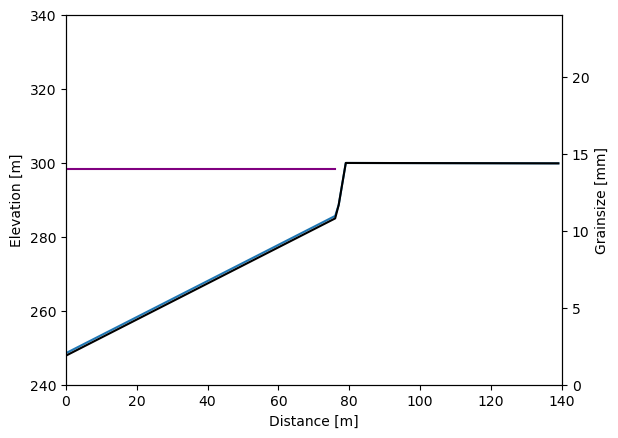

In [13]:
# Create simple plotting function for later
def plot_topography(grid):
    topo_p = grid.node_vector_to_raster(grid.at_node['topographic__elevation'])[:, 1]
    bedrock_p = grid.node_vector_to_raster(grid.at_node['bedrock__elevation'])[:, 1]
    ms = grid.node_vector_to_raster(grid.at_node['median__size_weight'])[:,1] * 1000 # in mm
    soil_p = grid.node_vector_to_raster(soil)[:,1]
    ms[soil_p<0.1] = np.nan
    
    fig, ax = plt.subplots()
    ax.plot(topo_p ),
    ax.plot(bedrock_p , color='k'),
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Elevation [m]')
    ax.set_ylim([240,340])
    ax.set_xlim([0,140])
    ax2 = ax.twinx()
    ax2.set_ylim([0,np.nanmax(ms)+10])
    ax2.set_ylabel('Grainsize [mm]')
    ax2.plot(ms,color = 'purple')
    plt.show()
    
# Ploting initial topography 
plot_topography(grid)

1


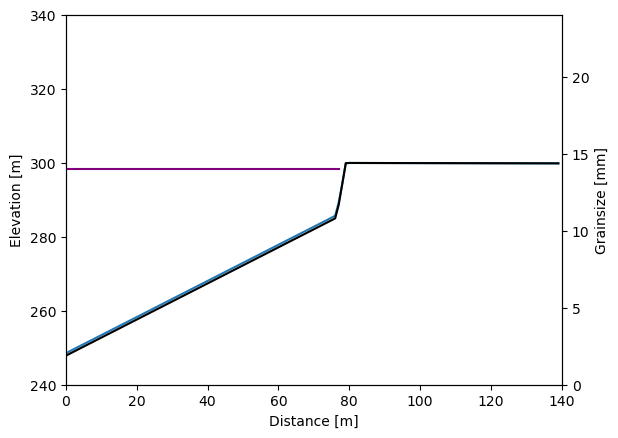

2
3
4


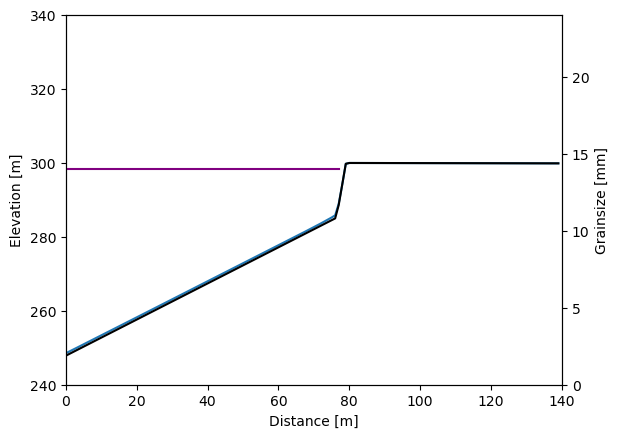

5
6
7


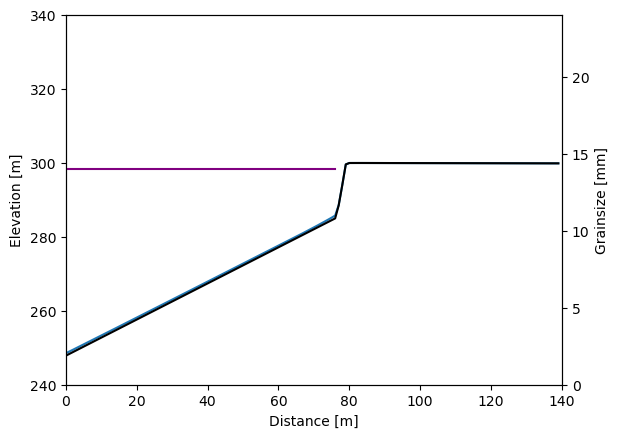

8
9
10


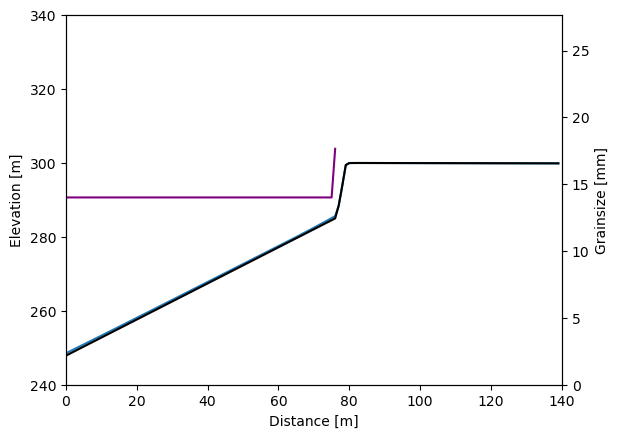

11
12
13


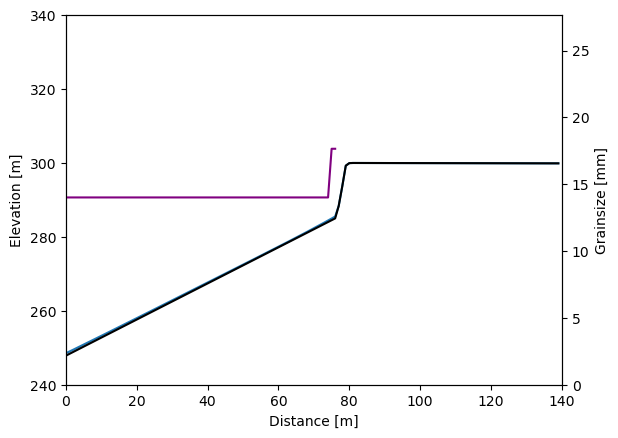

14
15
16


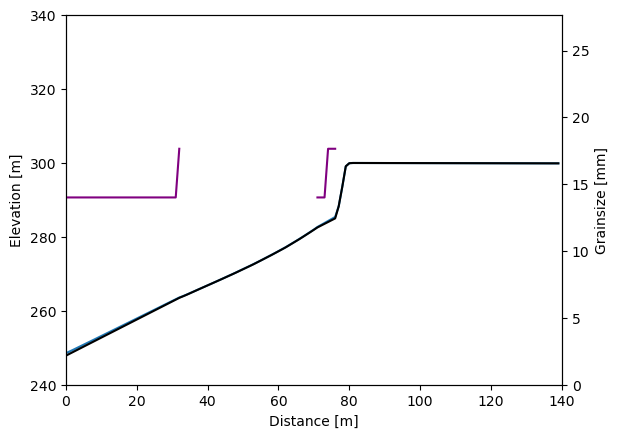

17
18
19


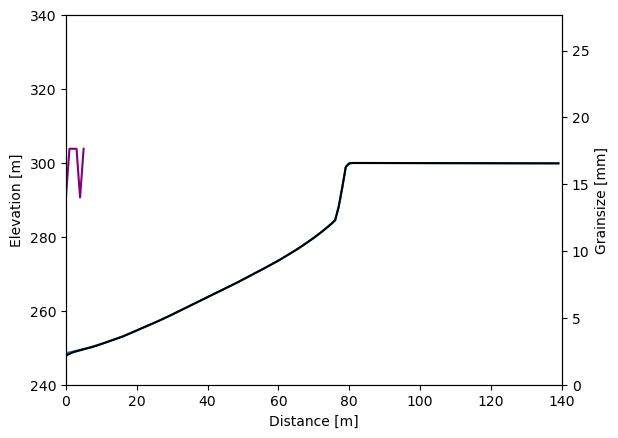

20
21
22


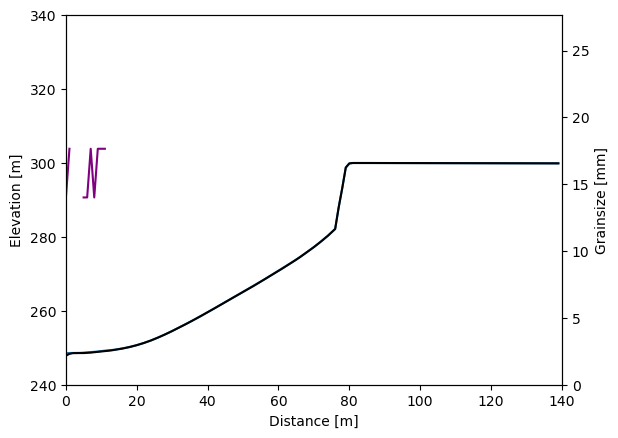

23
24
25


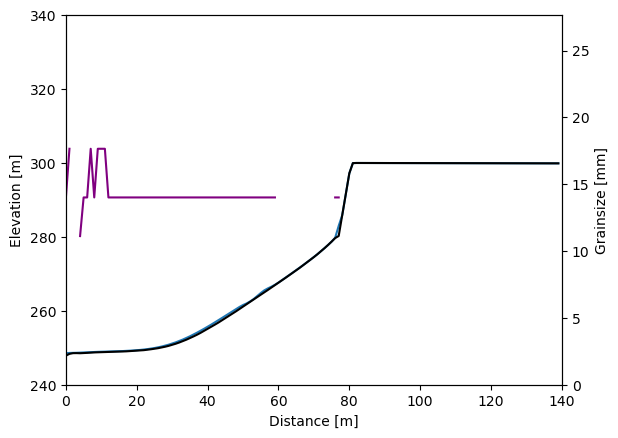

26
27
28


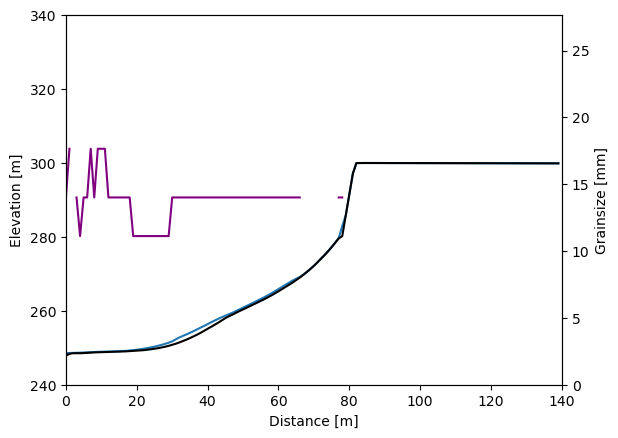

29
30
31


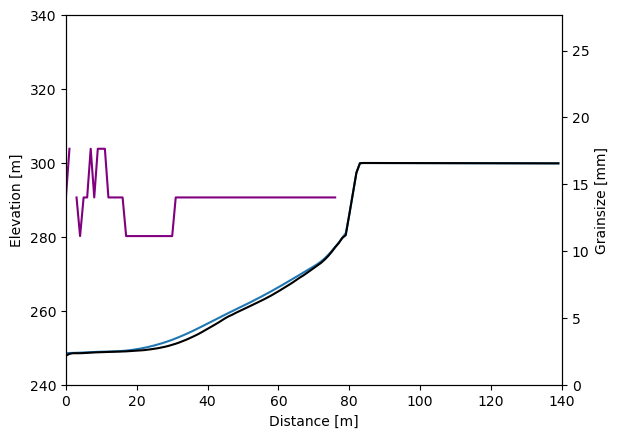

32
33
34


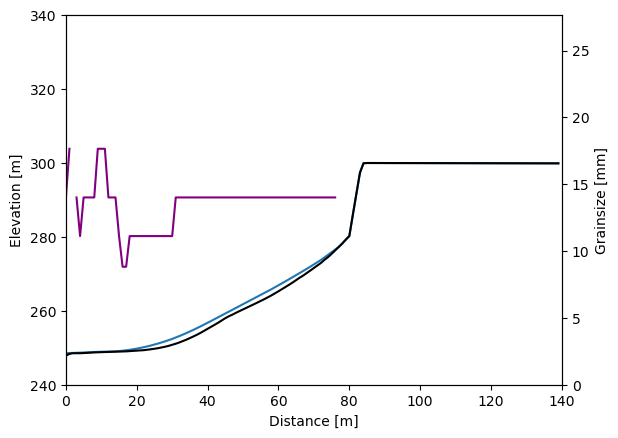

35
36
37


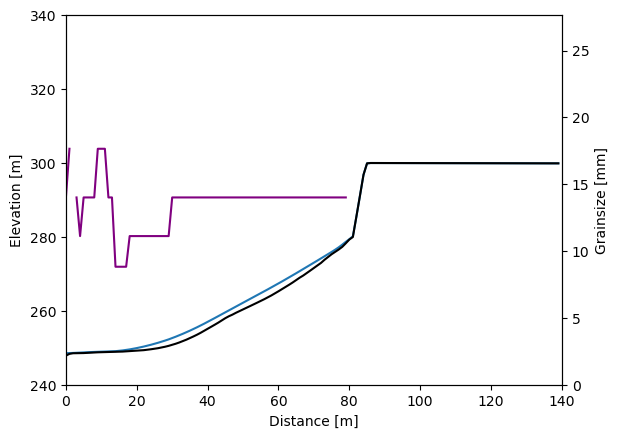

38
39
40


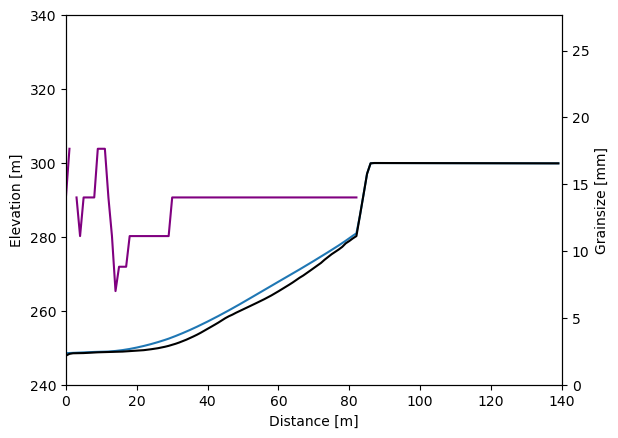

41
42
43


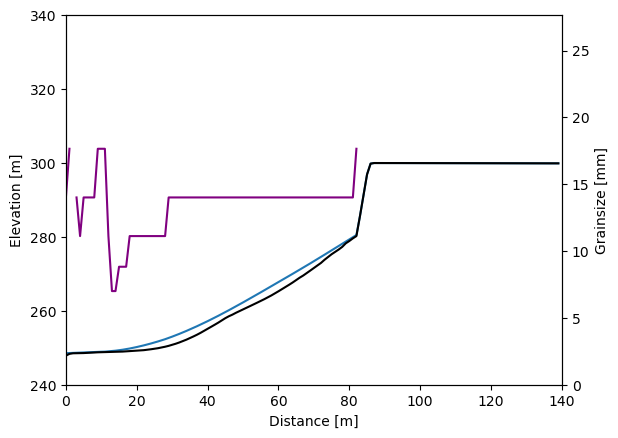

44
45
46


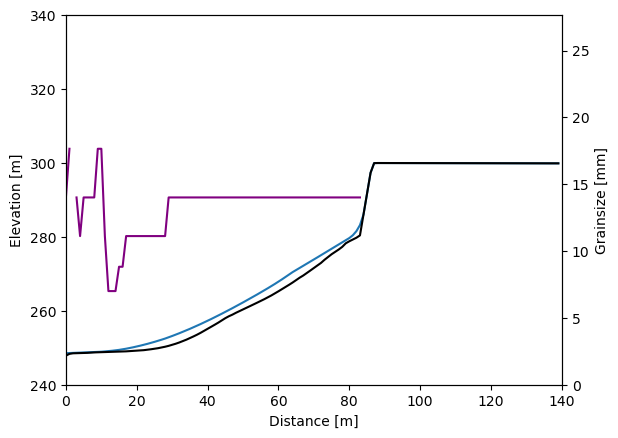

47
48
49


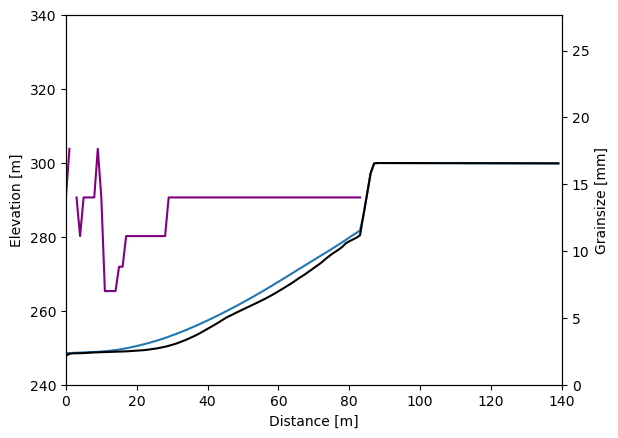

50
51
52


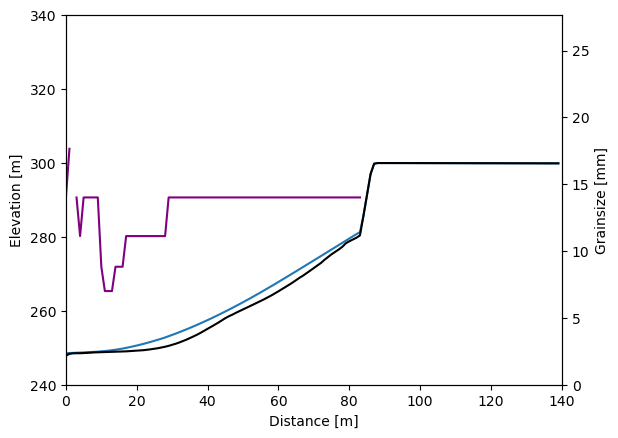

53
54
55


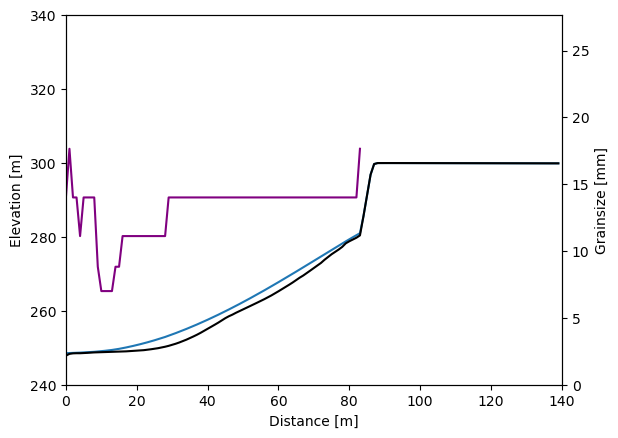

56
57
58


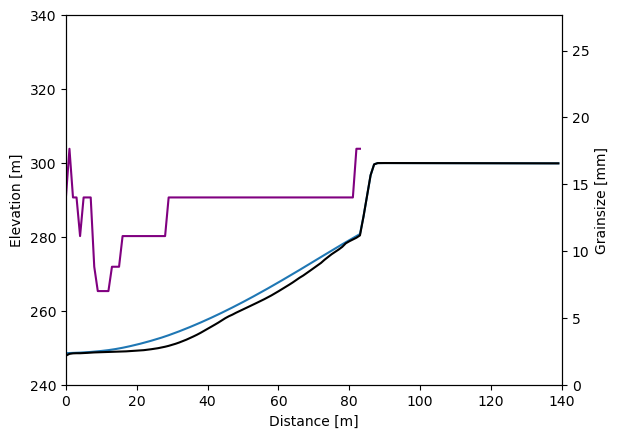

59
60
61


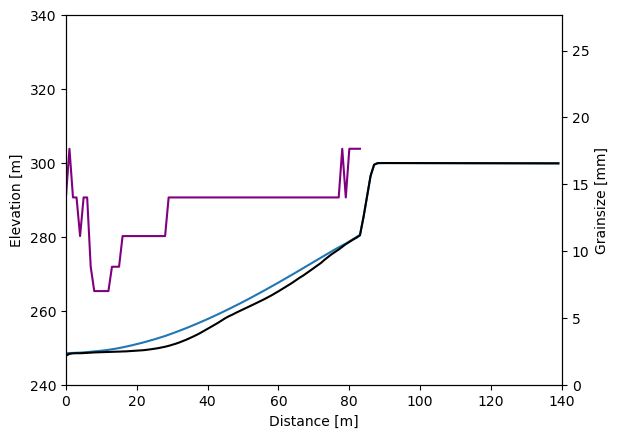

62
63
64


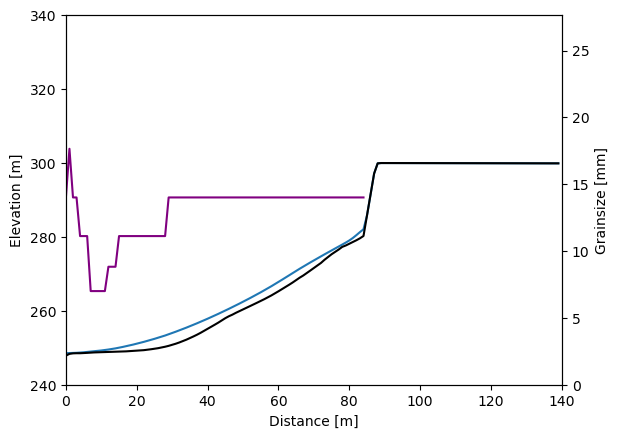

65
66
67


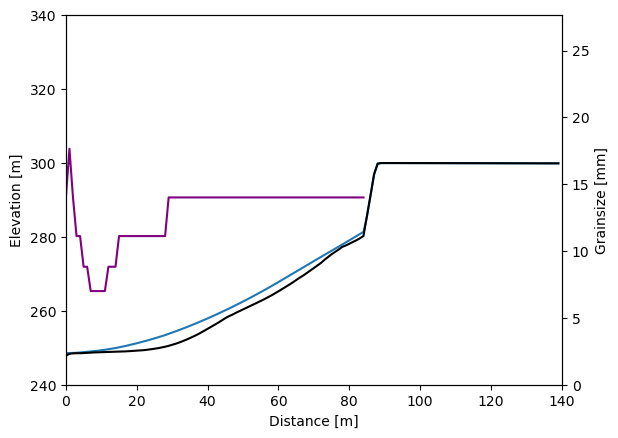

68
69
70


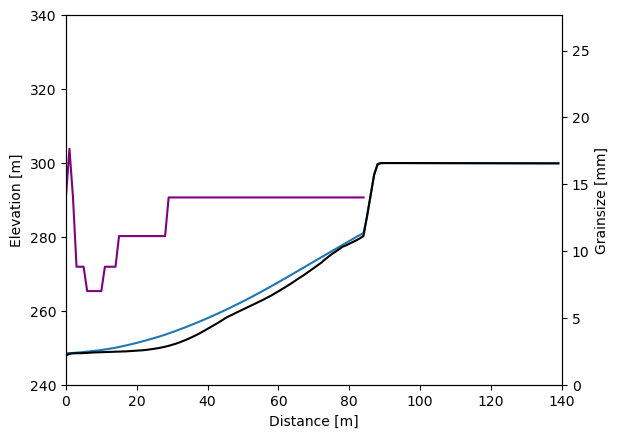

71
72
73


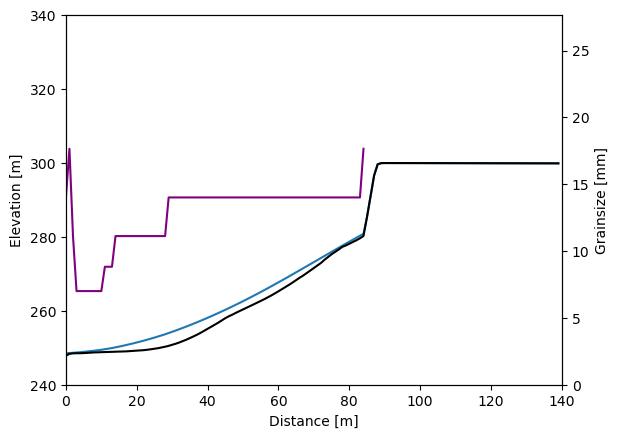

74
75
76


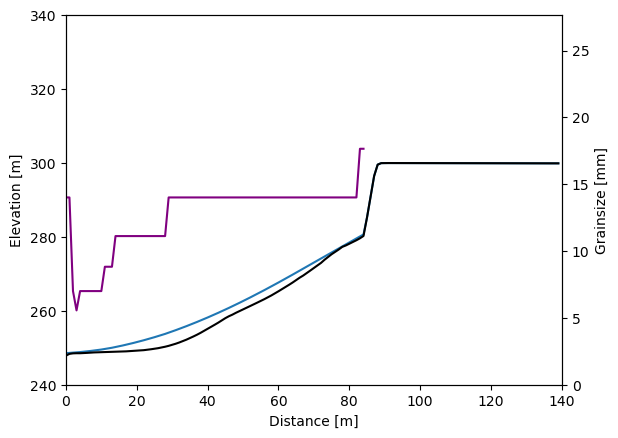

77
78
79


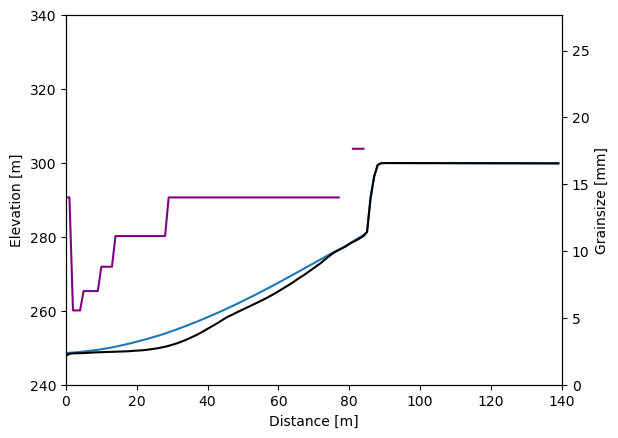

80
81
82


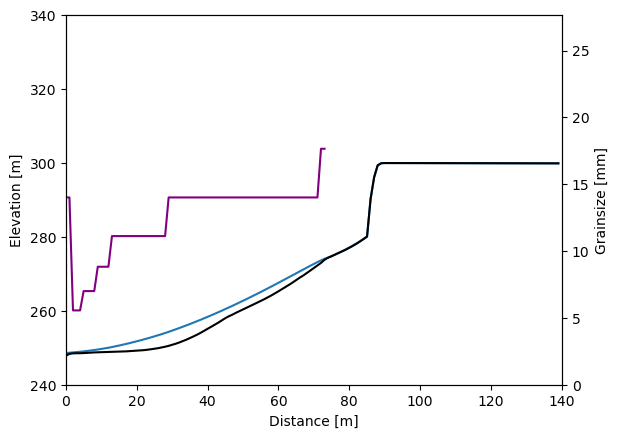

83
84
85


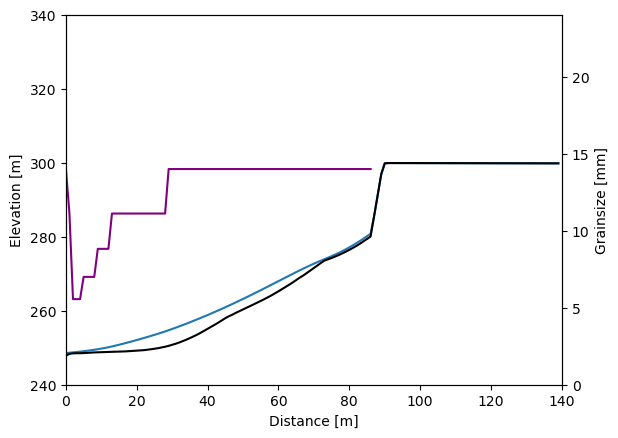

86
87
88


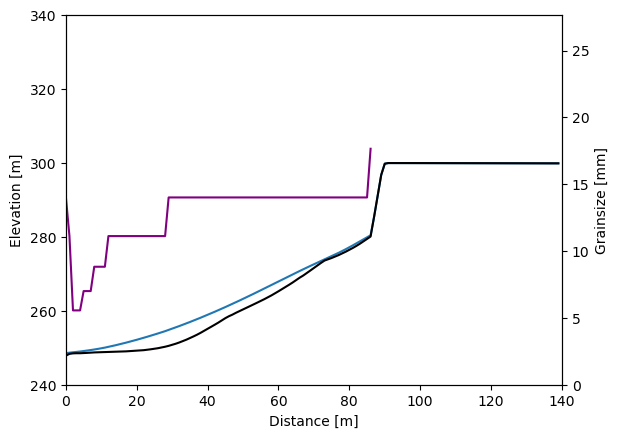

89
90
91


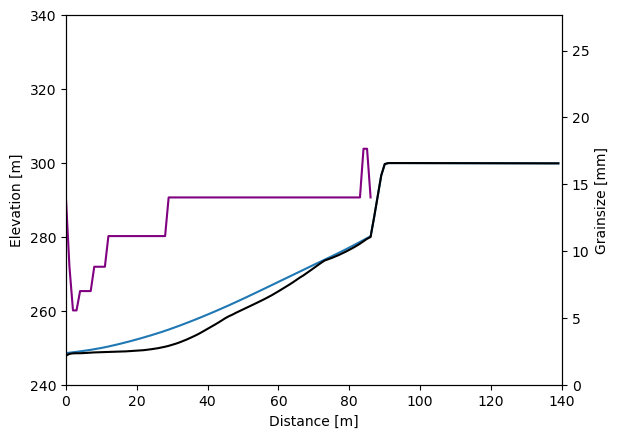

92
93
94


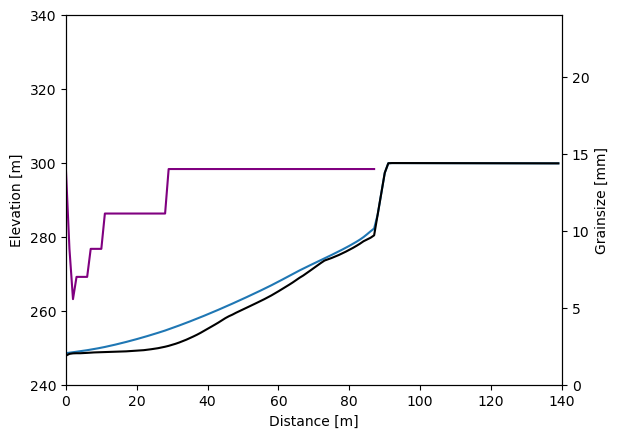

95
96
97


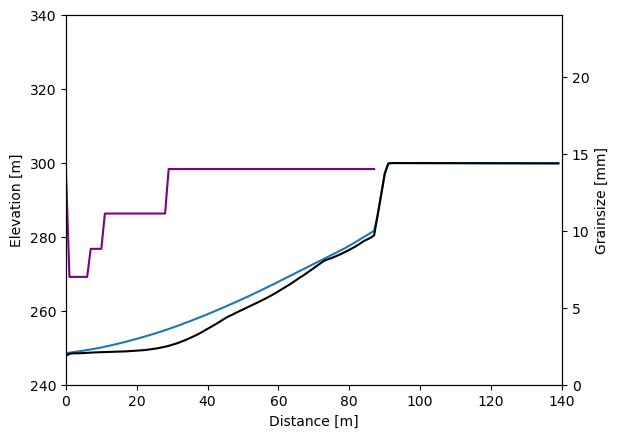

98
99
100


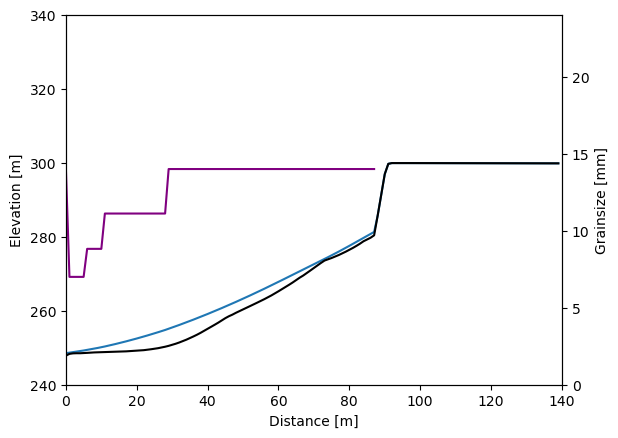

In [14]:
## Main ##

# Pointers
bedrock = grid.at_node['bedrock__elevation']
topo = grid.at_node['topographic__elevation']
soil  = grid.at_node['soil__depth']

# Simulation parameters
dt = 20 #Max dt
cnt=0
grid_size = np.size(grid.core_nodes)
epsilon = 1.0e-10

# Do: iterate over all storms
for storm_cnt in range(1, n_of_storm_to_simulate + 1):

    print(storm_cnt)
    rainfall_rate = rainfall_intensties[storm_cnt - 1, :]  # minute time steps.
    rainfall_duration = np.cumsum(rainfall_durations[storm_cnt - 1, :])  # minute time steps.
    rain_duration = (np.size(rainfall_rate) * 60)  # total rain durtaion inn sec
    nsteps = int(rain_duration / dt)
    infilitration_depth[:] = SI._min_water
    int_index = 0
    min_cnt = 60
    current_rainfall_duration = rainfall_duration[int_index]
    elapse_dts = 0

    fr.run_one_step()
    topo_before_diff = topo.copy()
    tl_diff.run_one_step(dt=1)
    topo[:] = topo_before_diff[:]
    CS.update_diffusive_mass(flux=grid.at_link['hillslope_sediment__unit_volume_flux'])
    topo[:] = soil[:] + bedrock[:]
    grading.update_sizes()
    fr.run_one_step()
    CS.weathering_run_one_step()
    CS.sediment_run_out()
    CS.update_deposited_mass()
    grading.update_sizes()
    
    grading.run_one_step(A_factor = 0.001)
    if storm_cnt>cnt:
        plot_topography(grid)
        cnt+=3

    print_time = 0
    cnt_intra = 0

    while elapse_dts < rainfall_duration[-1]:

        if elapse_dts >= current_rainfall_duration:  # sec
            int_index += 1
            grading.update_sizes()
            CS.update_cliff_state()
            current_rainfall_rate = rainfall_rate[int_index]
            current_rainfall_duration = rainfall_duration[int_index]
            ld.rainfall_intensity = current_rainfall_rate  # meter per sec -> For the OverlandFlow component

        gradmap.run_one_step()
        st.calc_dt()
        ld.calc_time_step()
        dspe.calc_E()
        dt_stable = DtCalc.calc_dt(dt_sediment = st._dt,
                                   dt_flow = ld._dt,
                                   dt_bedrock_incision=dspe._stable_dt)            # dt in sec

        dt_to_run = np.min((dt_stable, current_rainfall_duration - elapse_dts, dt))
        if (ld._dt == dt_to_run):
            dt_to_run = np.min((st._dt, dspe._stable_dt, dt))
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            sec_counter = 0
            while sec_counter<dt_to_run:
                dt_to_run_of = np.min((ld._dt, dt_to_run - sec_counter))
                ld.run_one_step(dt=dt_to_run_of)
                sec_counter +=  dt_to_run_of
                ld.calc_time_step()
        else:
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            ld.run_one_step(dt=dt_to_run)

        elapse_dts += dt_to_run
    while np.max(grid.at_node['surface_water__depth']) >= 0.001: 
        gradmap.run_one_step()
        ld.rainfall_intensity = epsilon
        st.calc_dt()
        ld.calc_time_step()
        dspe.calc_E()
        dt_stable = DtCalc.calc_dt(dt_sediment = st._dt,
                                   dt_flow = ld._dt,
                                   dt_bedrock_incision=dspe._stable_dt)           
        dt_to_run = np.min((dt_stable, dt))
        if (ld._dt == dt_to_run):
            dt_to_run = np.min((st._dt, dspe._stable_dt, dt))
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            sec_counter = 0
            while sec_counter < dt_to_run:
                dt_to_run_of = np.min((ld._dt, dt_to_run - sec_counter))
                ld.run_one_step(dt=dt_to_run_of)
                sec_counter += dt_to_run_of
                ld.calc_time_step()
        else:
            dspe.run_one_step(dt=dt_to_run)
            st.run_one_step(dt=dt_to_run)
            SI.run_one_step(dt=dt_to_run)
            ld.run_one_step(dt=dt_to_run)
    
    fr.run_one_step()
    CS.failure_run_one_step()
    fr.run_one_step()
    CS.sediment_run_out()
    CS.update_deposited_mass()
    grading.update_sizes()


In [15]:
SI._hydraulic_conductivity

'hydraulic_conductivity'

In [16]:
grid.at_node['hydraulic_conductivity']

array([  1.00000000e+02,   1.00000000e+02,   1.00000000e+02,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,   1.00000000e+02,   1.17898446e-06,
         1.17898446e-06,

In [17]:
topo_2D= grid.node_vector_to_raster(grid.at_node['topographic__elevation'])
bedrock_2D = grid.node_vector_to_raster(bedrock_topo)
init_topo_2D = np.copy(topo_2D)
# Call components
gradmap = GradMapper(grid=grid)

linear_diffusive_coef = grid.add_zeros('linear_diffusivity', at="node")
linear_diffusive_coef+=0.03
tl_diff = LinearDiffuser(grid, linear_diffusivity=linear_diffusive_coef)

cliff_nodes = grid.add_zeros('cliff_nodes', at="node")
cliff_nodes *= False
ld = OverlandFlow(grid, mannings_n=roughness, steep_slopes=True)
water_depth = grid.at_node['surface_water__depth']


imshow_grid(grid,'topographic__elevation')
plt.title('Initial topography')

NameError: name 'bedrock_topo' is not defined

In [72]:
s  = grid.at_node['soil__depth']
topo[:] = bedrock_topo[:] + s[:]
grading.g_state0

array([ 409,  250,  449,  779, 1503, 2617, 4665, 5495, 2106,   63])

In [62]:
## Calculate median size based on the grain size weight's in all grain size fractions

# grid.add_field("median__size_weight", np.ones((grid.shape[0], grid.shape[1])), at="node", dtype=float)
# # Median size based on weight
# def calc_median_size_by_weight(grid):
#     grid.at_node['grain__weight'][grid.at_node['grain__weight']<=0] = 0
#     a = np.cumsum(grid.at_node['grain__weight'], axis=1)
#     aa = np.sum(grid.at_node['grain__weight'], axis=1)
#     aa = np.round(aa, 1)
#     b = np.expand_dims(np.sum(grid.at_node['grain__weight'], axis=1), -1)
#     median_val_indx = np.argmin(np.abs(np.divide(a, b, out=np.zeros_like(a), where=b != 0) - 0.5), axis=1)
#     grid.at_node['median__size_weight'] =  sizes[median_val_indx[:]]
    
# calc_median_size_by_weight(grid)

# grid.delete_field(loc ='node', name='fraction_sizes')

# import pickle as pk
# with open('grid_example.pkl', 'wb') as file:
#     #
#     pk.dump(grid, file)

In [63]:
# ## Soil layer depth
# layer_depth = np.sum(volumes )/cell_area

# # Soil and hydraulic conductivity fields
# s = grid.add_zeros('soil__depth', at='node')
# s += layer_depth  #meters
# topo[:] = grid.at_node['bedrock__elevation'] + grid.at_node['soil__depth']

print('res')

res


/opt/anaconda3/envs/main/lib/python3.10/site-packages/landlab/plot/imshow.py:443: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/opt/anaconda3/envs/main/lib/python3.10/site-packages/landlab/plot/imshow.py:483: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


Text(0.5, 1.0, 'Initial topography')

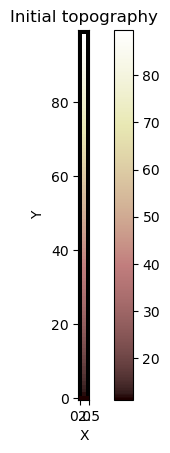

In [73]:

## Constants for the simulations
dt = 1 # sec
roughness = 0.04  # Maning's n
rainfall_rate = 80.0 * (0.001 / 3600.0)  # mm/h to m/s
epsilon = 1.0e-10  # arbitrarily small runoff rate for "no rain"
rho = 1000.0  # fluid density, kg/m3
sigma = 2000.0  # sediment density, kg/m3
g = 9.8  #
ks = 1. * 10 ** -6  # Hydraulic conducitivy m/s
rain_duration = 60*30 #30 min
run_duration =  rain_duration+ (60*10) # total run duration
k_e =  5*10**-5
tau_crit = 1
## Pointers
infil_depth = grid.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
infil_depth *= 0.03  ## meter
grid.add_ones("hydraulic_conductivity", at="node", dtype=float)
hydraulic_conductivity = grid.at_node['hydraulic_conductivity']*ks
topo_2D= grid.node_vector_to_raster(grid.at_node['topographic__elevation'])
bedrock_2D = grid.node_vector_to_raster(bedrock_topo)
init_topo_2D = np.copy(topo_2D)
# Call components
gradmap = GradMapper(grid=grid)
topographic_gradient_at_link = grid.add_zeros('topographic__elevation', at="link")
gradient_of_downwind_link_at_node = grid.add_zeros('downwind__link_gradient', at="node")
gradient_of_upwind_link_at_node = grid.add_zeros('upwnwind__link_gradient', at="node")
topographic_gradient_at_link = grid.add_zeros('topographic__gradient', at="link")
grid.add_zeros('water_surface__slope', at="node")
linear_diffusive_coef = grid.add_zeros('linear_diffusivity', at="node")
linear_diffusive_coef+=0.03
tl_diff = LinearDiffuser(grid, linear_diffusivity=linear_diffusive_coef)

cliff_nodes = grid.add_zeros('cliff_nodes', at="node")
cliff_nodes *= False

st = MPMtest2d(grid)
SI = SoilInfiltrationGreenAmpt(grid, hydraulic_conductivity=hydraulic_conductivity,
                               soil_type='silty clay',
                               initial_soil_moisture_content=0.05,
                               volume_fraction_coarse_fragments=0.1,
                               )
infilitration_depth = grid.at_node["soil_water_infiltration__depth"]
dspe = DepthSlopeProductErosion(
        grid,
        k_e= k_e,
        g=9.81,
        tau_crit = tau_crit,
        slope='water_surface__slope')

imshow_grid(grid,'topographic__elevation')
plt.title('Initial topography')


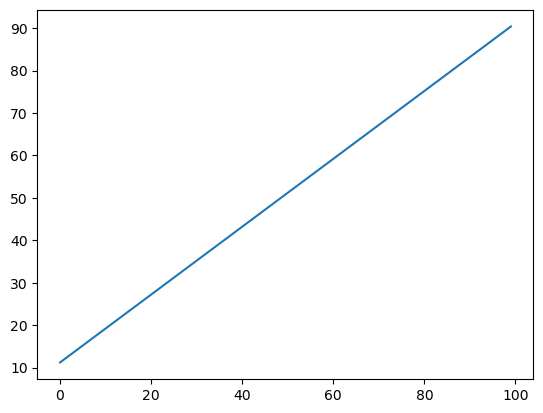

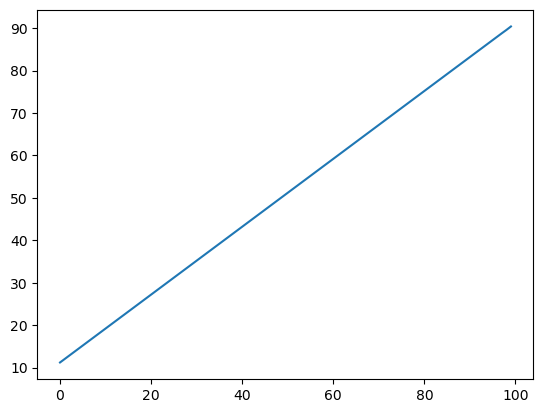

-0.024


In [65]:
#topo[grid.nodes[50:,1]]+=5
plt.plot(grid.node_vector_to_raster(grid.at_node['topographic__elevation'])[:,1]),plt.show()

for n in range(1):
    tl_diff.run_one_step(dt=1)

plt.plot(grid.node_vector_to_raster(grid.at_node['topographic__elevation'])[:,1]),plt.show()
print(np.min(grid.at_link['hillslope_sediment__unit_volume_flux']))

test


storm # 1
storm # 2
storm # 3
storm # 4
storm # 5
storm # 6
storm # 7
storm # 8
storm # 9
storm # 10
storm # 11
storm # 12
storm # 13
storm # 14
storm # 15
storm # 16
storm # 17
storm # 18
storm # 19
storm # 20
storm # 21
storm # 22
storm # 23
storm # 24
storm # 25
storm # 26
storm # 27
storm # 28
storm # 29
storm # 30
storm # 31
storm # 32
storm # 33
storm # 34
storm # 35
storm # 36
storm # 37
storm # 38
storm # 39
storm # 40
storm # 41
storm # 42
storm # 43
storm # 44
storm # 45
storm # 46
storm # 47
storm # 48
storm # 49
storm # 50
storm # 51
storm # 52
storm # 53
storm # 54
storm # 55
storm # 56
storm # 57
storm # 58
storm # 59
storm # 60
storm # 61
storm # 62
storm # 63
storm # 64
storm # 65
storm # 66
storm # 67
storm # 68
storm # 69
storm # 70
storm # 71
storm # 72
storm # 73
storm # 74
storm # 75
storm # 76
storm # 77
storm # 78
storm # 79
storm # 80
storm # 81
storm # 82
storm # 83
storm # 84
storm # 85
storm # 86
storm # 87
storm # 88
storm # 89
storm # 90
storm # 91
storm # 



fig, ax = plt.subplots(1,4, figsize= (20,5))
ax[0].plot(topo_2D[:,13]),
ax[1].plot(topo_2D[5,:]),
ax[2].plot(soil_2D[5,:]), 
ax[3].plot(d50_2D[5,:]), plt.show()



In [21]:
print('Total simulation time is : ' +  str(np.round(t2-t1)) + '[sec]')
grid.links_at_node[grid.nodes[30,5]]


Total simulation time is : 49.0[sec]


IndexError: index 5 is out of bounds for axis 1 with size 3

In [105]:
# row = 5
# topo_2D = grid.node_vector_to_raster(grid.at_node['topographic__elevation'])
# soil_2D = grid.node_vector_to_raster(grid.at_node['soil__depth'])
# d50_2D = np.log2(grid.node_vector_to_raster(grid.at_node['median__size_weight']))
# fig, ax = plt.subplots( figsize= (10,5))
# ax.plot(init_topo_2D[row,:], color = 'black', label = 'initial topography')
# ax.plot(topo_2D[row,:], color = 'red', label = 'final topography')
# ax.legend()
# ax.set_ylabel('Elevation [m]')
# ax.set_xlabel('Distance [m]')
# ax2 = plt.twinx()
# ax2.set_ylabel('D50 [m]', )
# ax2.plot(d50_2D[row,:], color = 'gray', label = 'd50')
# ax2.legend()
# ax.set_xlim([5,25])
# ax.set_ylim([1,25])

# plt.show()



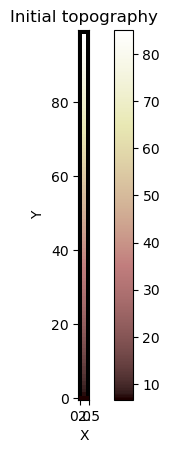

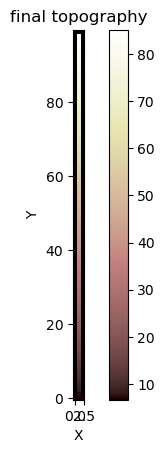

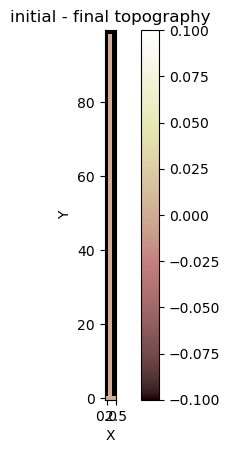

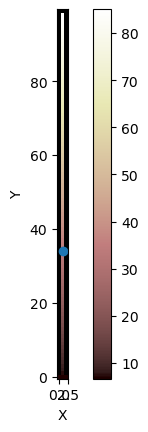

34.0

In [230]:

imshow_grid(grid,init_topo_2D.flatten()), plt.title('Initial topography'), plt.show()
imshow_grid(grid,topo.flatten()),  plt.title('final topography'), plt.show()
zdiff = topo - init_topo_2D.flatten()
imshow_grid(grid,zdiff), plt.title('initial - final topography'),plt.show()
imshow_grid(grid, init_topo_2D.flatten(),), plt.scatter(grid.node_x[103],grid.node_y[103]), plt.show()


grid.node_y[102]

In [231]:

#grid.node_vector_to_raster(grid.at_node['grain__weight'][:,0])

from landlab.components import FlowAccumulator, ChannelProfiler
fa = FlowAccumulator(grid, flow_director='D8')
fa.run_one_step()
profiler = ChannelProfiler(
    grid,
    number_of_watersheds=2,
    minimum_channel_threshold=20,
    main_channel_only=False)
profiler.run_one_step()
profiler.plot_profiles(), plt.show()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()
profiler.plot_profiles_in_map_view(color = 'white'), plt.show()
# fig, ax = plt.subplots()
# ax.plot(soil_2D[5,:], color = 'black'), 
# ax.plot(soil_2D[5,:], color = 'red'), plt.show()
Z = (grid.at_node['median__size_weight'])

ValueError: The number of watersheds requested by the ChannelProfiler is greater than the number in the domain with channel_definition_field area. [  0.  98.]

In [47]:
plt.plot(grid.node_vector_to_raster(grid.at_node['grain__weight'][:,10])[:,20])

IndexError: index 10 is out of bounds for axis 1 with size 10

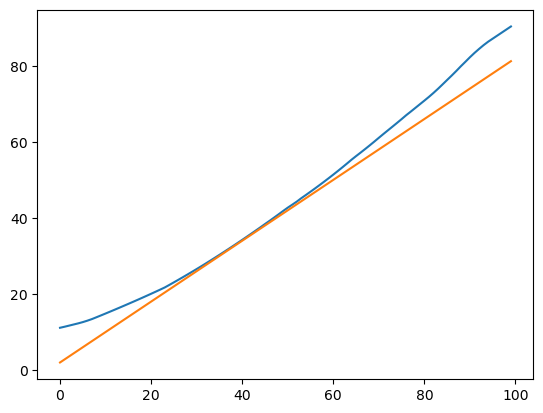

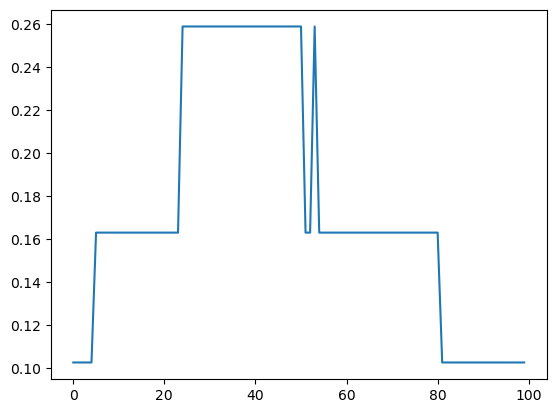

9.1225000000000005

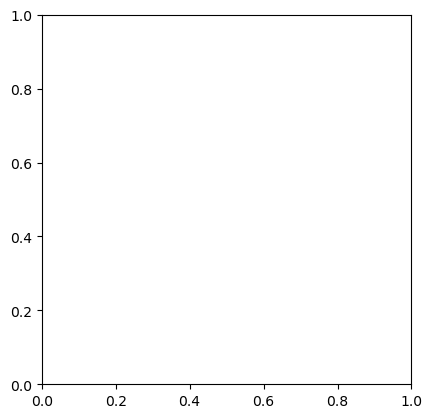

In [138]:

col = 1
topo2d = grid.node_vector_to_raster(grid.at_node['topographic__elevation'])
soil2d = grid.node_vector_to_raster(grid.at_node['soil__depth'])
bd2d = grid.node_vector_to_raster(grid.at_node['bedrock__elevation'])
d50 = grid.node_vector_to_raster(grid.at_node['median__size_weight'])
row = 1
col = 1
plt.plot(topo2d[:,col]),plt.plot(bd2d[:,col]),plt.show()
plt.plot(d50[:,col]),plt.show()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
np.max(soil2d )

40


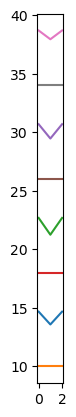

40


IndexError: index 3 is out of bounds for axis 1 with size 3

In [30]:

for row in range(10,50,10):
    plt.plot(topo2d[row,:]),plt.plot(grid.node_vector_to_raster( bedrock_topo)[row,:]),
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
print(row)
plt.show()

print(row)
col = 25
cols =[3,4,5]
for col in cols:
    plt.plot(topo2d[:,col])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
plt.show()


In [47]:


# ## OLD OLD OLD OLD OLD OLD OLD OLD OLD OLD

# fig, ax = plt.subplots( figsize= (10,5))
# ax.plot(topo_2D[:,10], color = 'red'), 
# ax.plot(init_topo_2D[:,10], color = 'black'), plt.show()

# fig, ax = plt.subplots( figsize= (10,5))
# ax.plot(d50_2D[5,:], color = 'red'), 
# d50_2D = grid.node_vector_to_raster(grid.at_node['median__size_area'])
# d50_2D_w = grid.node_vector_to_raster(grid.at_node['median__size_weight'])
# d50_2D_c = grid.node_vector_to_raster(grid.at_node['median__size'])

# topo_2D= grid.node_vector_to_raster(grid.at_node['topographic__elevation'])
# soil_2D = grid.node_vector_to_raster(s)
# bedrock_2D = grid.node_vector_to_raster(bedrock_topo)

# fig, ax = plt.subplots()
# ax.plot(topo_2D[1:-1,6] ,color='b', linewidth=1, label='Topography')
# plt.plot(bedrock_2D[1:-1,6]  , color='k', linewidth=1, label='Bedrock')
# plt.legend(loc='upper left')
# plt.xlabel('Distance [m]')
# plt.ylabel('Elevation [m]')
# ax2 = plt.twinx()
# ax2.set_ylabel('D50 [m]')
# window = 1
# ax2.plot(range(len(moving_average(d50_2D[1:-1, 1], window))), moving_average(d50_2D[1:-1, 1], window),
#          '-o',color='gray', label = 'd50_by_area' )
# ax2.plot(range(len(moving_average(d50_2D_w[1:-1, 1], window))), moving_average(d50_2D_w[1:-1, 1], window),
#          '-o',color='pink' , label = 'd50_by_weight')
# ax2.plot(range(len(moving_average(d50_2D_c[1:-1, 1], window))), moving_average(d50_2D_c[1:-1, 1], window),
#          '-o',color='green' , label = 'd50_by_counts')
# ax2.axhline(y=initial_median_clast_size_on_slope, color='gray', linestyle='--', label = 'initial d50')
# #ax2.set_ylim([np.min(d50_2D[1:-1,1])-0.001, np.max(d50_2D_w[1:-1,1])+0.001])
# ax2.legend(loc='lower right')
# plt.title('Storm #' + str(storm_cnt) + '\n maxsize = ' + str(
#     round(maxsize * 1000)) + '[mm],  init layer depth = ' + str(int(layer_depth)) + '[m]')
# plt.savefig('D:\\Yuval\\Phd\\SlopeTalusRill_modeling\\outputs\\testing_d50_representation'+ '.png', dpi=400)
# plt.show()



# imshow_grid(grid,'median__size_weight'), plt.show()
#print(grid.at_node['median__size_weight'])
#np.sum(grid.at_node['grain__weight'][grid.nodes[:,1],:],axis=1)

grid.at_node['median__size_weight'][grid.nodes[:,1]]


array([ 0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20374507,
        0.20374507,  0.20374507,  0.20374507,  0.20374507,  0.20

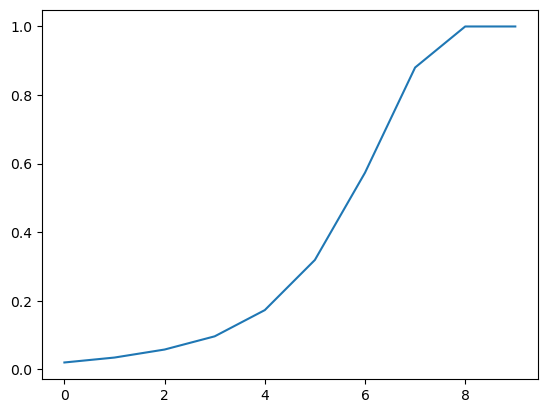

In [251]:

node = 15
plt.plot(np.cumsum(grid.at_node['grain__weight'][node ,:]) / np.sum(grid.at_node['grain__weight'][node ,:]))

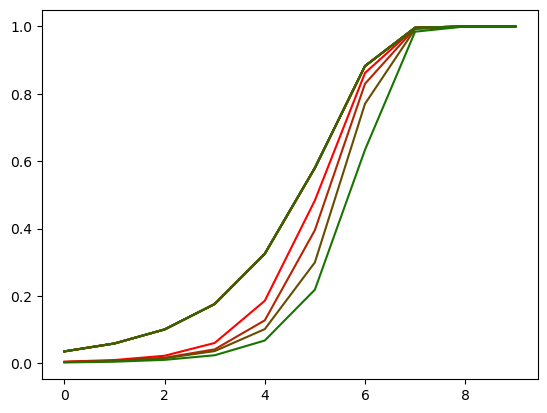

In [102]:
nodes = np.arange(4,100,10)
import matplotlib as mpl


def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='red' #red
c2='green' #green
colors = []
for n in range(np.size(nodes)):
    colors.append(colorFader(c1,c2,n/np.size(nodes)))
                                             
for node,color in zip(nodes,colors):
    plt.plot(np.cumsum(grid.at_node['grain__weight'][node ,:]) / np.sum(grid.at_node['grain__weight'][node ,:]), color= color)
    

In [247]:
np.arange(4,500,100)

array([  4, 104, 204, 304, 404])

In [248]:
grid.nodes

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
       [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
       [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29],
       [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
       [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
       [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
       [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
       [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
       [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
       [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
       [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
       [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
       [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
       [150, 151, 152, 153, 154, 155, 156, 157, 158, 159],
       [160, 161, 162, 163, 164, 165, 166, 167, 168, 169

In [ ]:

# ##  Create grid and topography
# nrows = 100  # Domain rows
# ncols = 3  # Domain columns
# dx = 1.0  # node size
# cell_area = dx ** 2  # node area
# init_slope = 0.8  # m/m

# # Create Grid Element
# grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
# grid.set_closed_boundaries_at_grid_edges(True, True, True, False)      # Open boundary at the bottom
# grid.at_node['topographic__elevation'] = 2 + grid.node_y*init_slope  # Constant slope topography
# topo = grid.at_node['topographic__elevation']                         # Pointer for topography
# topo[grid.core_nodes] = 2 + grid.node_y[grid.core_nodes] *init_slope # 
# bedrock_topo = grid.add_zeros('bedrock__elevation', at='node')        # Field for bedrock elevation
# bedrock_topo[:] = grid.at_node['topographic__elevation'].copy()       # Copy the topographic elevation to be the bedrock elevation
# midpt = int(0.5 * np.amax(grid.x_of_node))                                
# bedrock_topo[grid.core_nodes] += 0.005 * (grid.x_of_node[grid.core_nodes] - midpt)**(2) # Create concave topography